In [2]:
import MNISTtools
import numpy as np
from matplotlib import pyplot as plt

ModuleNotFoundError: No module named 'MNISTtools'

In [34]:
xtrain, ltrain=MNISTtools.load(dataset="training", path="../mnist")

In [35]:
xtrain.shape

(784, 60000)

In [36]:
xtrain.size

47040000

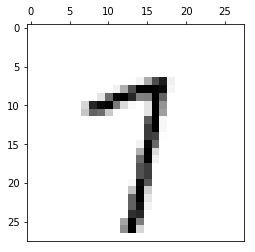

7

In [37]:
MNISTtools.show(xtrain[:,42])
ltrain[42]

In [38]:
def normalize_MNIST_images(x):
    return ((x-127.5)/127.5).astype(np.float64)

In [39]:
def label2onehot(lbl):
    d=np.zeros((lbl.max()+1, lbl.size))
    d[lbl, np.arange(lbl.size)]=1
    return d

dtrain=label2onehot(ltrain)
print(dtrain[:,42])
print(ltrain[42])

[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
7


In [40]:
def onehot2label(d):
    lbl=d.argmax(axis=0)
    return lbl

In [41]:
print(all(ltrain==onehot2label(dtrain)))

True


In [42]:
def softmax(a):
    M=a.max(axis=0)
    z=np.exp(a-M)
    return z/z.sum(axis=0)

In [43]:
def softmaxp(a, e):
    return (e-np.sum(softmax(a)*e, axis=0))*softmax(a)

In [44]:
eps=1e-6
a=np.random.randn(10, 200)
e=np.random.randn(10, 200)
diff=softmaxp(a,e)
diff_approx=(softmax(a+eps*e)-softmax(a))/eps
rel_error=np.abs(diff-diff_approx).mean()/np.abs(diff_approx).mean()
print(rel_error, 'should be smaller than 1e-6')

4.819145946773821e-07 should be smaller than 1e-6


In [45]:
def relu(a):
    return (a>0)*a
    
def relup(a, e):
    return (a>0)*e

In [52]:
def init_shallow(Ni, Nh, No):
    b1 = np.random.randn(Nh, 1)   / np.sqrt((Ni+1.)/2.)
    W1 = np.random.randn(Nh, Ni)  / np.sqrt((Ni+1.)/2.)
    b2 = np.random.randn(No, 1)   / np.sqrt((Nh+1.))
    W2 = np.random.randn(No, Nh)  / np.sqrt((Nh+1.))
    return W1, b1, W2, b2

Ni = xtrain.shape[0]
Nh = 64
No = dtrain.shape[0]
netinit = init_shallow(Ni, Nh, No)


In [53]:
def forwardprop_shallow(x, net):
    W1=net[0]
    b1=net[1]
    W2=net[2]
    b2=net[3]
    
    a1=W1.dot(x)+b1
    h1=relu(a1)
    a2=W2.dot(h1)+b2
    y=softmax(a2)
    
    return y

xtrain=normalize_MNIST_images(xtrain)
yinit=forwardprop_shallow(xtrain, netinit)

In [24]:
def eval_loss(y, d):
    return -np.sum(d*np.log(y))/d.size

print(eval_loss(yinit, dtrain), 'should be around .26')

0.2906548910384183 should be around .26


In [25]:
def eval_perfs(y, lbl):
    ylabel=onehot2label(y)
    return 100*(ylabel!=lbl).mean()

print(eval_perfs(yinit, ltrain))

92.07


In [26]:
def update_shallow(x, d, net, gamma=.05):
    W1 = net[0]
    b1 = net[1]
    W2 = net[2]
    b2 = net[3]
    Ni = W1.shape[1]
    Nh = W1.shape[0]
    No = W2.shape[0]

    gamma = gamma / x.shape[1]

    a1=W1.dot(x)+b1
    h1=relu(a1)
    a2=W2.dot(h1)+b2
    y=softmax(a2)

    delta2=softmaxp(a2, -d/y)
    delta1=relup(a1, W2.T.dot(delta2))
    
    #경사하강법
    W2=W2-gamma*delta2.dot(h1.T)
    W1=W1-gamma*delta1.dot(x.T)
    b2=b2-gamma*delta2.sum(axis=1, keepdims=True)
    b1=b1-gamma*delta1.sum(axis=1, keepdims=True)
    
    return W1, b1, W2, b2


In [27]:
def backprop_shallow(x, d, net, T, gamma=.05):
    lbl = onehot2label(d)
    for t in range(T):
        net=update_shallow(x, d, net, gamma)
        predict=forwardprop_shallow(x, net)
        loss=eval_loss(predict, d)
        miss=eval_perfs(predict, lbl)
        print(str(t)+", loss="+str(loss)+", error rate="+str(miss))
    return net

In [ ]:
nettrain = backprop_shallow(xtrain, dtrain, netinit, 100)

0, loss=0.2502271290474666, error rate=85.26166666666667
1, loss=0.22446395722998227, error rate=81.45333333333333
2, loss=0.21301375374468068, error rate=73.77833333333334
3, loss=0.20499385657957184, error rate=68.43833333333333


In [ ]:
xtest, ltest = MNISTtools.load(dataset = "testing", path = "../mnist")
xtest = normalize_MNIST_images(xtest)
dtest = label2onehot(ltest)
print(xtest.shape)
print(ltest.shape)

In [ ]:
predict = forwardprop_shallow(xtest,nettrain)
loss = eval_loss(predict,dtest)
miss = eval_perfs(predict,ltest)
print(loss)
print(miss)

In [ ]:
def backprop_minibatch_shallow(x, d, net, T, B=100, gamma=.05):
    N=x.shape[1]
    NB=int((N+B-1)/B)
    lbl=onehot2label(d)
    for t in range(T):
        shuffled_indices=np.random.permutation(range(N))
        for l in range(NB):
            minibatch_indices=shuffled_indices[B*l:min(B*(l+1), N)]
            index=np.arange(B*l, min(B*(l+1), N))
            net=update_shallow(x[:, index], d[:, index], net, gamma)
        y=forwardprop_shallow(x, net)
        loss=eval_loss(y, d)
        miss=eval_perfs(y, lbl)
        print(str(loss)+" "+str(miss))

    return net

netminibatch=backprop_minibatch_shallow(xtrain, dtrain, netinit, 5, B=100)

In [ ]:
prd=forwardprop_shallow(xtest, netminibatch)
loss = eval_loss(prd,dtest)
miss = eval_perfs(prd,ltest)
print(loss)
print(miss)